In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

import joblib

import lightgbm as lgb
from lightgbm import LGBMClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

NameError: name 'np' is not defined

In [5]:
raw_data = pd.read_csv('training_data/bband_training_data_long_31_0520.csv')

In [11]:
ls = 'long_ret'
# ls = 'short_ret'
# for long dataset out == 1 & side == 1 or -1
training_data = raw_data.copy()
training_data['out'] = training_data['out'].apply(lambda x:1 if x == 1 else 0)
training_data = training_data.sort_values(by=['date'])
training_data['side'] = training_data['side'].apply(lambda x:1 if x == 3 else 0)
# training_data = training_data[training_data.side == 3]
# training_data = training_data[training_data.date > '2021-05-03']
print(f'training_data.shape : {training_data.shape}')

col_list = ['date', 'side', 'com_rev', 'd_yield', 'pb', 'AD', 'OBV', 'ADOSC', 'bias5',
    'bias10', 'bias20', 'bias60', 'acc5', 'acc10', 'acc20', 'acc60', 'rsi',
    'log_ret', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'volatility',
    'MA5', 'MA20', 'MA60', 'MACD', 'signal', 'hist',
    'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5',
    'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5', 'b_OBV', 'b_AD', 'b_ADOSC',
    'b_MA5', 'b_MA20', 'b_MA60', 'b_bias5', 'b_bias10', 'b_bias20', 'b_bias60',
    'b_acc5', 'b_acc10', 'b_acc20', 'b_acc60', 'b_volatility', 'long_ret', 'short_ret', 'out']

# train_data = training_data[col_list]
data = training_data[col_list].iloc[:int(training_data.shape[0]*.5),:]
train_data = data.iloc[:int(data.shape[0]*.7),:]
print(train_data.shape)
test_data = data.iloc[int(data.shape[0]*.7):,:]
print(test_data.shape)

training_data.shape : (651429, 59)
(227999, 58)
(97715, 58)


In [12]:
print(f'train_data.date.min {train_data.date.min()}')
print(f'train_data.date.max {train_data.date.max()}')
print(f'train_data.shape {train_data.shape}')
# print(f'test_data.date.min {test_data.date.min()}')
# print(f'test_data.date.max {test_data.date.max()}')
# print(f'test_data.shape {test_data.shape}')

train_data.date.min 2016-12-27
train_data.date.max 2017-09-29
train_data.shape (227999, 58)


In [13]:
test_data.tail()

,date,side,com_rev,d_yield,pb,AD,OBV,ADOSC,bias5,bias10,...,b_bias20,b_bias60,b_acc5,b_acc10,b_acc20,b_acc60,b_volatility,long_ret,short_ret,out
290057,2018-01-17,0,-0.609280,0.066667,0.272727,-0.600494,0.639627,-0.342002,-0.178746,-0.212176,...,0.686707,0.451683,0.037075,-0.007002,-0.687102,-0.05189,-0.680571,-0.011420,0.009420,0
109210,2018-01-17,0,-0.389296,0.533333,0.066667,0.051775,0.122097,0.515768,0.648580,0.502418,...,0.686707,0.451683,0.037075,-0.007002,-0.687102,-0.05189,-0.680571,-0.009852,0.007852,0
401256,2018-01-17,0,-0.768978,0.142276,-0.114286,0.022830,0.069275,-0.676686,-0.146027,-0.163255,...,0.686707,0.451683,0.037075,-0.007002,-0.687102,-0.05189,-0.680571,-0.031282,0.029282,0
301552,2018-01-17,0,0.490715,-0.894737,0.576419,-0.242191,0.612600,0.110282,0.298468,0.149810,...,0.686707,0.451683,0.037075,-0.007002,-0.687102,-0.05189,-0.680571,0.080860,-0.082860,1
536086,2018-01-17,0,-0.095415,-0.801205,0.047619,0.135489,-0.545503,-0.320252,0.052353,-0.256444,...,0.686707,0.451683,0.037075,-0.007002,-0.687102,-0.05189,-0.680571,-0.029310,0.027310,0


In [14]:
def Upsample(df):
    # Separate majority and minority classes
    shape_0 = df[df.out==0].shape[0]
    shape_1 = df[df.out==1].shape[0]
    if shape_0 > shape_1:
        df_majority = df[df.out==0]
        df_minority = df[df.out==1]
        n = 0
    else:
        df_majority = df[df.out==1]
        df_minority = df[df.out==0]
        n = 1
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=df.out.value_counts()[n],    # to match majority class
                                    random_state=123) # reproducible results
    
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    # Display new class counts
    print(f'before\n {df.out.value_counts()}')
    print(f'after\n {df_upsampled.out.value_counts()}')
    return df_upsampled

train_data_up = Upsample(train_data)
# test_data_up = Upsample(test_data)
# train_data_up = train_data_up.sample(frac=0.9, replace=True, random_state=1)

X = train_data_up.iloc[:,1:-3]
y = train_data_up.iloc[:,-1]
X_test = test_data.iloc[:,1:-3]
y_test = test_data.iloc[:,-1]

before
 0    161241
1     66758
Name: out, dtype: int64
after
 1    161241
0    161241
Name: out, dtype: int64


In [17]:
y.head()

319463    0
319970    0
320477    0
322505    0
323012    0
Name: out, dtype: int64

<AxesSubplot:>

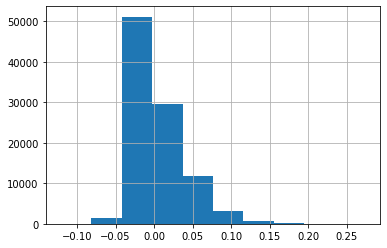

In [15]:
test_data[ls].hist()

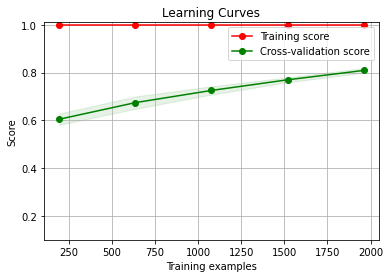

In [17]:
# digits = load_digits()
# X, y = digits.data, digits.target


title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# estimator = BernoulliNB()
estimator = lgb.LGBMClassifier(objective = 'binary', 
                                learning_rate = 0.05, 
                                n_estimators = 500, 
                                random_state=0)
plot_learning_curve(estimator, title, X, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4)

# title = "Learning Curves (ExtraTreesClassifier)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = RandomForestClassifier(max_depth=15, random_state=0, n_estimators=500, bootstrap=True)
# estimator = ExtraTreesClassifier(
#     n_estimators=100, criterion="entropy", random_state=0, class_weight='balanced',
#     warm_start=True, bootstrap=True
#     )
# # plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
# #                         n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))
# plot_learning_curve(estimator, title, X, y, (0.1, 1.01), cv=cv, n_jobs=4)

plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11873
           1       0.32      1.00      0.48      5551

    accuracy                           0.32     17424
   macro avg       0.16      0.50      0.24     17424
weighted avg       0.10      0.32      0.15     17424

Confusion Matrix
[[    0 11873]
 [    0  5551]]

Accuracy
0.3185835629017447
long_ret


c:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


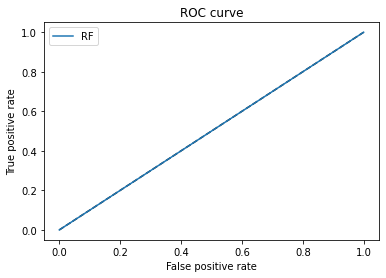

In [18]:
primary_data = raw_data.copy()
primary_data['out'] = primary_data['out'].apply(lambda x:1 if x == 1 else 0)
primary_data = primary_data.sort_values(by=['date'])
primary_data = primary_data[primary_data.side == 3]
primary_data['side'] = 1

p_pred = primary_data.side
p_test = primary_data.out
fpr_rf, tpr_rf, _ = roc_curve(p_test, p_pred)
print(classification_report(p_test, p_pred))
cf_matrix = confusion_matrix(p_test, p_pred)
print("Confusion Matrix")
print(cf_matrix)

print('')
print("Accuracy")
print(accuracy_score(p_test, p_pred))
print(ls)
# print(sum(test_data[ls]))
# print("AVG")
# print(sum(test_data[ls])/len(test_data[ls]))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [19]:
# ex_clf = ExtraTreesClassifier(
#     n_estimators=1000, criterion="entropy", random_state=0, class_weight='balanced',
#     warm_start=True, bootstrap=True
#     )
# ex_clf = RandomForestClassifier(max_depth=15, random_state=42, n_estimators=500, bootstrap=True)
# ex_clf.fit(X, y)
ex_clf = lgb.LGBMClassifier(objective = 'binary', 
                                learning_rate = 0.05, 
                                n_estimators = 1000, 
                                random_state=47)
# ex_clf = BernoulliNB()
ex_clf.fit(X, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=47, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

              precision    recall  f1-score   support

           0       0.75      0.80      0.77     69319
           1       0.42      0.37      0.39     28396

    accuracy                           0.67     97715
   macro avg       0.59      0.58      0.58     97715
weighted avg       0.66      0.67      0.66     97715

Confusion Matrix
[[55196 14123]
 [18015 10381]]

Accuracy
0.6711047433863787
long_ret
332.3476262364234


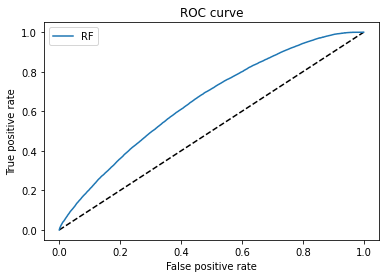

In [20]:
model = ex_clf
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cf_matrix)

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

print(ls)
print(sum(y_pred_rf * test_data[ls].to_numpy()))
# print("AVG")
# print(sum(y_pred_rf * test_data[ls].to_numpy())/len(test_data[ls]))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:
a = test_data[ls].to_numpy()
print('Primary')
print(f"total earning {sum(a)}")
print(f'trade {np.count_nonzero(a)} times')
print(f'{sum(a)/len(a)}')
b = []
c = 0
for item in list(a):
    if item != 0:
        b.append(item)
        if item > 0:
            c += 1
print(f'Wining Rate {c/np.count_nonzero(a)}')
print('')
for thres in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    # g = lambda x: x if x > thres else 0
    # vfunc = np.vectorize(g)
    # with_thres = vfunc(y_pred_rf)
    with_thres = []
    for item in y_pred_rf:
        if item > thres:
            with_thres.append(item)
        else:
            with_thres.append(0)
    a = with_thres * test_data[ls].to_numpy()
    print(f'ML threshold :{thres}')
    print(f'trade {np.count_nonzero(with_thres)} times')
    print(f"total earning {sum(a)}")
    print('AVG')
    b = []
    c = 0
    for item in list(a):
        if item != 0:
            b.append(item)
            if item > 0:
                c += 1
    print(sum(a)/len(b))
    print(f'Wining Rate {c/np.count_nonzero(with_thres)}')
    print('')
    

Primary
total earning 594.9909528454486
trade 97715 times
0.006089044188153801
Wining Rate 0.4427262958604104

ML threshold :0.2
trade 81768 times
total earning 335.2855151109938
AVG
0.0041004490156417404
Wining Rate 0.47615203991781624

ML threshold :0.3
trade 65868 times
total earning 318.5381859102047
AVG
0.004836008166487591
Wining Rate 0.49597680208902656

ML threshold :0.4
trade 45083 times
total earning 269.4617414883004
AVG
0.005977014428682661
Wining Rate 0.521615686622452

ML threshold :0.5
trade 24504 times
total earning 182.91995571187908
AVG
0.00746490188181028
Wining Rate 0.5504407443682664

ML threshold :0.6
trade 9600 times
total earning 93.91529924260772
AVG
0.00978284367110497
Wining Rate 0.5882291666666667

ML threshold :0.7
trade 2252 times
total earning 29.20708315885789
AVG
0.01296939749505235
Wining Rate 0.6620781527531083

ML threshold :0.8
trade 256 times
total earning 5.2152071500959565
AVG
0.02037190293006233
Wining Rate 0.81640625

ML threshold :0.9
trade 9 

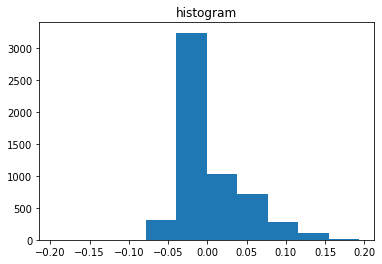

In [13]:
# plt.hist(with_thres * test_data['long_ret'].to_numpy()) 
plt.hist(test_data['long_ret'].to_numpy()) 
plt.title("histogram") 
plt.show()

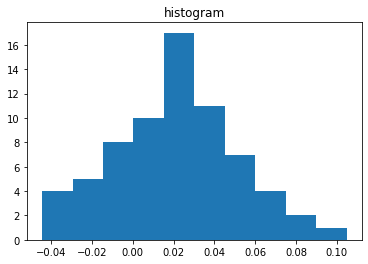

In [37]:
thres = .9
with_thres = []
for item in y_pred_rf:
    if item > thres:
        with_thres.append(item)
    else:
        with_thres.append(0)
b = []
for item in list(with_thres * test_data['long_ret'].to_numpy()):
    if item != 0:
        b.append(item)
plt.hist(b, bins=10) 
# plt.hist(test_data['long_ret'].to_numpy()) 
plt.title("histogram") 
plt.show()

<AxesSubplot:>

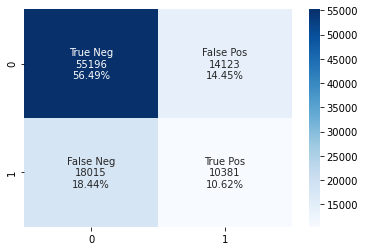

In [22]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

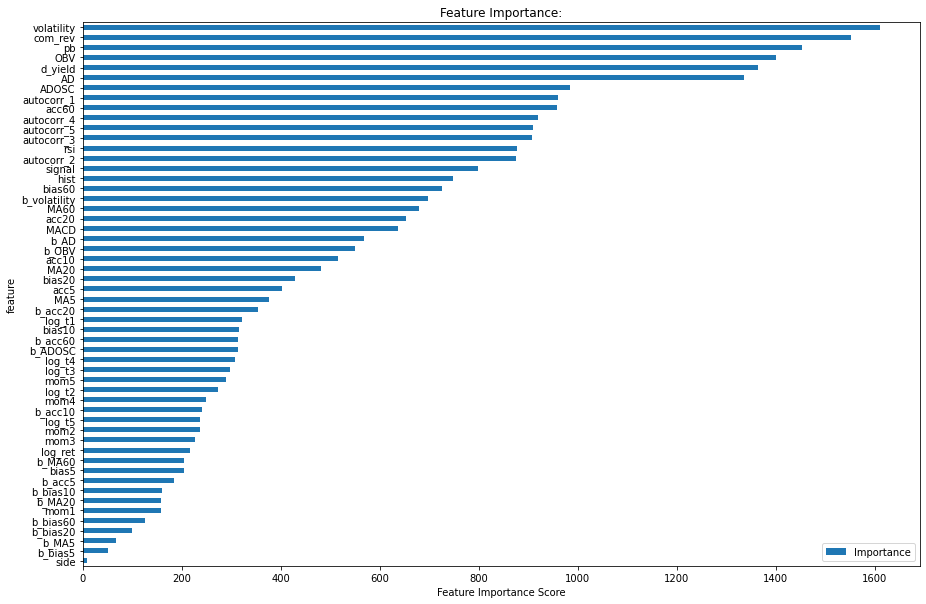

In [23]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 10)

feat_imp = pd.DataFrame({'Importance':model.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

In [63]:
joblib.dump(model,'lazypredict/trend_long_LGBM_31_0521.pkl')

['lazypredict/trend_long_LGBM_31_0521.pkl']

In [3]:
# model = ex_clf
raw_data = pd.read_csv('training_data/bband_training_data_long_31_test.csv')

In [4]:
print(f'raw_data.date.min {raw_data.date.min()}')
print(f'raw_data.date.max {raw_data.date.max()}')
print(f'raw_data.shape {raw_data.shape}')

raw_data.date.min 2019-07-03
raw_data.date.max 2022-03-16
raw_data.shape (908721, 59)


In [13]:
training_data = raw_data.copy()
training_data['out'] = training_data['out'].apply(lambda x:1 if x == 1 else 0)
training_data = training_data.sort_values(by=['date'])
training_data = training_data[training_data.side == 1]
# training_data = training_data[training_data.date > '2021-05-03']
print(f'training_data.shape : {training_data.shape}')

col_list = ['date', 'com_rev', 'd_yield', 'pb', 'AD', 'OBV', 'ADOSC', 'bias5',
    'bias10', 'bias20', 'bias60', 'acc5', 'acc10', 'acc20', 'acc60', 'rsi',
    'log_ret', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'volatility',
    'MA5', 'MA20', 'MA60', 'MACD', 'signal', 'hist',
    'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5',
    'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5', 'b_OBV', 'b_AD', 'b_ADOSC',
    'b_MA5', 'b_MA20', 'b_MA60', 'b_bias5', 'b_bias10', 'b_bias20', 'b_bias60',
    'b_acc5', 'b_acc10', 'b_acc20', 'b_acc60', 'b_volatility', 'long_ret', 'short_ret', 'out']

test_data = training_data[col_list]
# train_data = data.iloc[:int(training_data.shape[0]*.7),:]
# print(train_data.shape)
# test_data = data.iloc[int(training_data.shape[0]*.7):,:]
print(test_data.shape)
X_test = test_data.iloc[:,1:-3]
y_test = test_data.iloc[:,-1]

training_data.shape : (30373, 59)
(30373, 57)


              precision    recall  f1-score   support

           0       0.77      0.86      0.81     22976
           1       0.30      0.18      0.23      7397

    accuracy                           0.70     30373
   macro avg       0.54      0.52      0.52     30373
weighted avg       0.65      0.70      0.67     30373

Confusion Matrix
[[19873  3103]
 [ 6046  1351]]

Accuracy
0.6987785203964048
long_ret
87.54346315939719


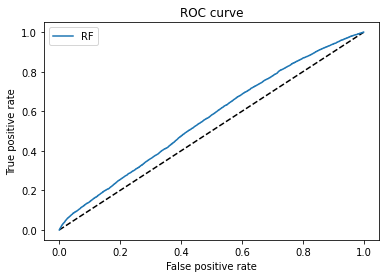

In [14]:
ls = 'long_ret'
model = joblib.load(r'C:\Users\Drey\finlab_ml_course\lazypredict\mrs_long_LGBM_31_0520.pkl')
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cf_matrix)

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

print(ls)
print(sum(y_pred_rf * test_data[ls].to_numpy()))
# print("AVG")
# print(sum(y_pred_rf * test_data[ls].to_numpy())/len(test_data[ls]))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [15]:
a = test_data[ls].to_numpy()
print('Primary')
print(f"total earning {sum(a)}")
print(f'trade {np.count_nonzero(a)} times')
print(f'{sum(a)/len(a)}')
b = []
c = 0
for item in list(a):
    if item != 0:
        b.append(item)
        if item > 0:
            c += 1
print(f'Wining Rate {c/np.count_nonzero(a)}')
print('')
for thres in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    # g = lambda x: x if x > thres else 0
    # vfunc = np.vectorize(g)
    # with_thres = vfunc(y_pred_rf)
    with_thres = []
    for item in y_pred_rf:
        if item > thres:
            with_thres.append(item)
        else:
            with_thres.append(0)
    a = with_thres * test_data[ls].to_numpy()
    print(f'ML threshold :{thres}')
    print(f'trade {np.count_nonzero(with_thres)} times')
    print(f"total earning {sum(a)}")
    print('AVG')
    b = []
    c = 0
    for item in list(a):
        if item != 0:
            b.append(item)
            if item > 0:
                c += 1
    print(sum(a)/len(b))
    print(f'Wining Rate {c/np.count_nonzero(with_thres)}')
    print('')

Primary
total earning 301.5614288118433
trade 30373 times
0.00992860200875262
Wining Rate 0.4378230665393606

ML threshold :0.2
trade 15720 times
total earning 73.39525407967625
AVG
0.00466890929260027
Wining Rate 0.4576972010178117

ML threshold :0.3
trade 10991 times
total earning 61.644223139125614
AVG
0.00560860914740475
Wining Rate 0.459466836502593

ML threshold :0.4
trade 7290 times
total earning 50.46295735384398
AVG
0.006922216372269408
Wining Rate 0.462002743484225

ML threshold :0.5
trade 4454 times
total earning 40.49705135880557
AVG
0.00909228813623834
Wining Rate 0.4732824427480916

ML threshold :0.6
trade 2577 times
total earning 32.72070486539943
AVG
0.012697207941559733
Wining Rate 0.5013581684128832

ML threshold :0.7
trade 1387 times
total earning 25.874485056677614
AVG
0.018655000040863456
Wining Rate 0.55155010814708

ML threshold :0.8
trade 677 times
total earning 18.467046468919666
AVG
0.027277764355863612
Wining Rate 0.6307237813884786

ML threshold :0.9
trade 2

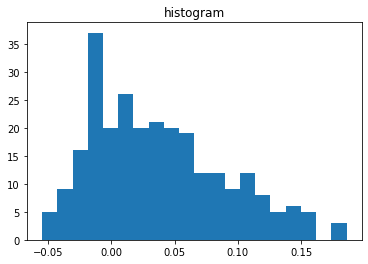

In [16]:
thres = .9
with_thres = []
for item in y_pred_rf:
    if item > thres:
        with_thres.append(item)
    else:
        with_thres.append(0)
b = []
for item in list(with_thres * test_data['long_ret'].to_numpy()):
    if item != 0:
        b.append(item)
plt.hist(b, bins=20) 
# plt.hist(test_data['long_ret'].to_numpy()) 
plt.title("histogram") 
plt.show()

In [25]:
import shap

In [27]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(X_test)
shap.initjs()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


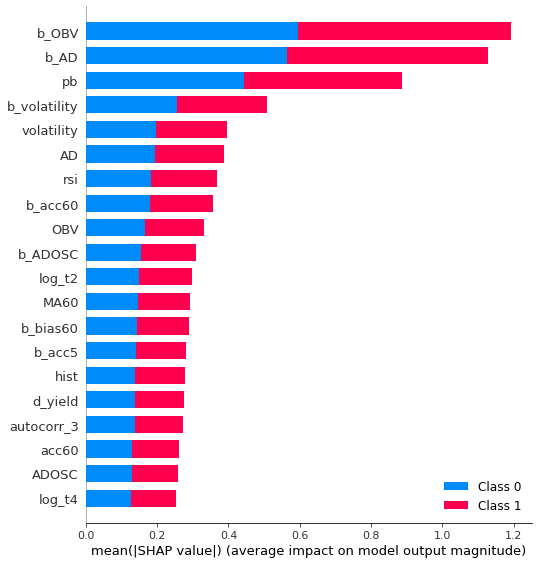

In [28]:
shap.summary_plot(shap_values, X_test)

In [32]:
shap.force_plot(explainer.expected_value, shap_values[10], X_test.iloc[10,:])

IndexError: list index out of range

In [36]:
shap_values.size

AttributeError: 'list' object has no attribute 'size'